In [1]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import os
import json
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import create_directory

In [2]:
save_path = os.path.join(create_directory.result_dir, 'test_threshold/fixed_threshold/cosine_similarity')
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Load Data

In [3]:
data_path = os.path.join(create_directory.marvel_data_dir, "distance_face_recognition/fixed_threshold")

In [4]:
# label2idx
with open(os.path.join(create_directory.recognition_model_dir, 'label2idx.json')) as json_file:
    label2idx = json.load(json_file)

# Big data
with open(os.path.join(data_path, "train_feature_big.json"), "r") as outfile:
    x_train_big = json.load(outfile)
with open(os.path.join(data_path, "test_feature_big.json"), "r") as outfile:
    x_test_big = json.load(outfile)
with open(os.path.join(data_path, "train_label_idx_big.json"), "r") as outfile:
    y_train_big = json.load(outfile)
with open(os.path.join(data_path, "test_label_idx_big.json"), "r") as outfile:
    y_test_big = json.load(outfile)

# Small data
with open(os.path.join(data_path, "train_feature_small.json"), "r") as outfile:
    x_train_small = json.load(outfile)
with open(os.path.join(data_path, "test_feature_small.json"), "r") as outfile:
    x_test_small = json.load(outfile)
with open(os.path.join(data_path, "train_label_idx_small.json"), "r") as outfile:
    y_train_small = json.load(outfile)
with open(os.path.join(data_path, "test_label_idx_small.json"), "r") as outfile:
    y_test_small = json.load(outfile)

# Face recognition

## Cài đặt hàm

In [5]:
# Các hàm nhận diện khuôn mặt
def nearest_recognition(feat, train_labels, train_feats, threshold):
    candidate_label = []
    candidate_similarity = []
    for label, vector in zip(train_labels, train_feats):
        similarity = cosine_similarity(np.array(feat).reshape(1, -1), np.array(vector).reshape(1, -1))[0][0]
        if similarity>threshold:
            candidate_label.append(label)
            candidate_similarity.append(similarity)
    if len(candidate_label)==0:
        return label2idx["Unknown"]
    else:
        return candidate_label[candidate_similarity.index(max(candidate_similarity))]

def naive_neighbour_recognition(feat, train_labels, train_feats, threshold):
    candidate_label = []
    candidate_similarity = []
    for label, vector in zip(train_labels, train_feats):
        similarity = cosine_similarity(np.array(feat).reshape(1, -1), np.array(vector).reshape(1, -1))[0][0]
        if similarity>threshold:
            candidate_label.append(label)
            candidate_similarity.append(similarity)
    if len(candidate_label)==0:
        return label2idx["Unknown"]
    else:
        df_candidate=pd.DataFrame({'Label': candidate_label})
        df_candidate_count = pd.DataFrame(df_candidate["Label"].value_counts().to_dict().items(), columns=['Label','Count'])
        list_candidate = list(df_candidate_count[df_candidate_count['Count']==max(df_candidate_count['Count'])]['Label'])
        if len(list_candidate) == 1:
            return max(candidate_label, key = candidate_label.count)
        else:
            df_candidate_similarity=pd.DataFrame({'Label': candidate_label, 'Similarity': candidate_similarity})
            best_candidate = df_candidate_similarity[df_candidate_similarity['Label'].isin(list_candidate)].groupby('Label').mean().to_dict()['Similarity']
            return max(best_candidate, key = best_candidate.get)

In [6]:
threshold_list = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
# Lấy kết quả dự đoán ứng với các threshold tương ứng
def test_threshold(threshold_list, x_train, x_test, y_train, type):
    recognition_result = {}
    for i in threshold_list:
        print("Threshold: "+str(i))
        if type=="nearest":
            recognition_result[i] = [nearest_recognition(j, y_train, x_train, i) for j in x_test]
        if type=="naive_neighbour":
            recognition_result[i] = [naive_neighbour_recognition(j, y_train, x_train, i) for j in x_test]
    return recognition_result

def metric(true, pred):
    fa = 0  # False accept
    wa = 0  # Wrong answer
    fr = 0  # False reject
    accept = 0
    reject = 0

    for (i, j) in zip(true, pred):
        # Hệ thống nhận diện khuôn mặt đó có trong database
        if j != label2idx["Unknown"]:
            accept+=1
            # Hệ thống nhận diện khuôn mặt Unknown thành khuôn mặt trong database
            if i == label2idx["Unknown"]:
                fa+=1
            else:
                # Hệ thống nhận diện nhầm khuôn mặt trong database
                if i!=j:
                    wa+=1
        else:
            reject+=1
            if i != label2idx["Unknown"]:
                fr+=1
    # Mong muốn giảm fa, wa
    return (fa, wa, fr, accept, reject)

In [7]:
# Plot confusion matrix
idx2label = {y: x for x, y in label2idx.items()}
def show_result(result, y_test, threshold):
    pred = result[threshold]
    fa, wa, fr, accept, reject = metric(y_test, pred)
    acc = accuracy_score(y_test, pred)
    print("Threshold = "+str(threshold))
    print("Accuracy: {}, Accept: {}, False Accept: {}, Wrong Recognition: {}, Reject: {}, False Reject: {}".format(acc, accept, fa, wa, reject, fr))
    print("")
    array = confusion_matrix(y_test, pred)
    df_cm = pd.DataFrame(array, index = [idx2label[i] for i in range(7)], 
                        columns = [idx2label[i] for i in range(7)])
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.title("Confusion matrix with threshold = "+str(threshold))
    plt.show()

# Save result
def save_result(result, y_test, save_path):
    thresh_list, fa_list, wa_list, fr_list, accept_list, reject_list, accuracy_list = [], [], [], [], [], [], []
    for threshold, pred in result.items():
        fa, wa, fr, accept, reject = metric(y_test, pred)
        acc = accuracy_score(y_test, pred)
        thresh_list.append(threshold)
        fa_list.append(fa)
        wa_list.append(wa)
        fr_list.append(fr)
        accept_list.append(accept)
        reject_list.append(reject)
        accuracy_list.append(acc)
    dict = {'threshold': thresh_list, 'accept': accept_list, 'fa': fa_list, 'wa': wa_list, 
            'reject': reject_list, 'fr': fr_list, 'accuracy': accuracy_list} 
    df = pd.DataFrame(dict)
    df.to_csv(save_path, index=False)

## Big dataset

### Nearest candidate

In [8]:
big_nearest_recognition_result = test_threshold(threshold_list, x_train_big, x_test_big, y_train_big, type='nearest')

Threshold: 0.4
Threshold: 0.45
Threshold: 0.5
Threshold: 0.55
Threshold: 0.6
Threshold: 0.65
Threshold: 0.7
Threshold: 0.75
Threshold: 0.8
Threshold: 0.85
Threshold: 0.9
Threshold: 0.95


In [9]:
save_result(big_nearest_recognition_result, y_test_big, os.path.join(save_path, "big_nearest_candidate_threshold_test.csv"))

Phương pháp 1: Nearest candidate + Big dataset
Threshold = 0.6
Accuracy: 0.8637532133676092, Accept: 377, False Accept: 50, Wrong Recognition: 2, Reject: 12, False Reject: 1



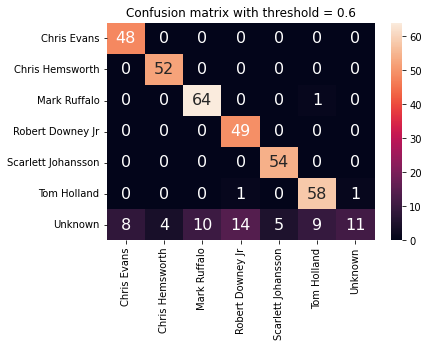

In [10]:
print("Phương pháp 1: Nearest candidate + Big dataset")
show_result(big_nearest_recognition_result, y_test_big, threshold=0.6)

### Naive Neighbour candidates

In [11]:
big_naive_neighbour_recognition_result = test_threshold(threshold_list, x_train_big, x_test_big, y_train_big, type='naive_neighbour')

Threshold: 0.4
Threshold: 0.45
Threshold: 0.5
Threshold: 0.55
Threshold: 0.6
Threshold: 0.65
Threshold: 0.7
Threshold: 0.75
Threshold: 0.8
Threshold: 0.85
Threshold: 0.9
Threshold: 0.95


In [12]:
save_result(big_naive_neighbour_recognition_result, y_test_big, os.path.join(save_path, "big_naive_neighbour_candidate_threshold_test.csv"))

Phương pháp 2: Naive Neigbour candidates + Big dataset
Threshold = 0.6
Accuracy: 0.8688946015424165, Accept: 377, False Accept: 50, Wrong Recognition: 0, Reject: 12, False Reject: 1



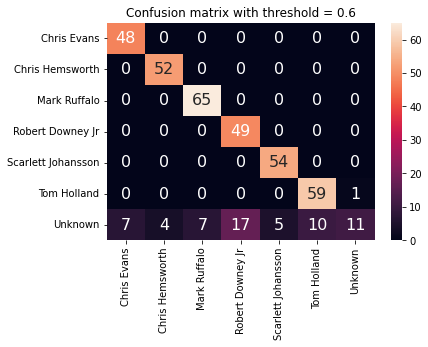

In [13]:
print("Phương pháp 2: Naive Neigbour candidates + Big dataset")
show_result(big_naive_neighbour_recognition_result, y_test_big, threshold=0.6)

## Small dataset

### Nearest candidate

In [17]:
small_nearest_recognition_result = test_threshold(threshold_list, x_train_small, x_test_small, y_train_small, type='nearest')

Threshold: 0.4
Threshold: 0.45
Threshold: 0.5
Threshold: 0.55
Threshold: 0.6
Threshold: 0.65
Threshold: 0.7
Threshold: 0.75
Threshold: 0.8
Threshold: 0.85
Threshold: 0.9
Threshold: 0.95


In [18]:
save_result(small_nearest_recognition_result, y_test_small, os.path.join(save_path, "small_nearest_candidate_threshold_test.csv"))

Phương pháp 1: Nearest candidate + Small dataset
Threshold = 0.6
Accuracy: 0.810304449648712, Accept: 419, False Accept: 56, Wrong Recognition: 23, Reject: 8, False Reject: 2



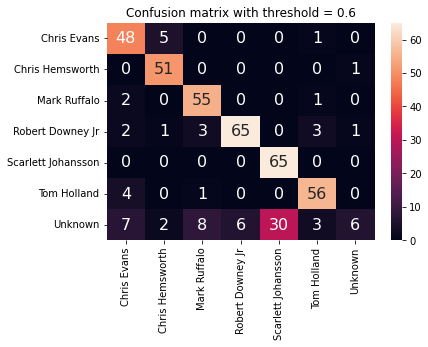

In [19]:
print("Phương pháp 1: Nearest candidate + Small dataset")
show_result(small_nearest_recognition_result, y_test_small, threshold=0.6)

### Naive Neighbour candidates

In [20]:
small_naive_neighbour_recognition_result = test_threshold(threshold_list, x_train_small, x_test_small, y_train_small, type='naive_neighbour')

Threshold: 0.4
Threshold: 0.45
Threshold: 0.5
Threshold: 0.55
Threshold: 0.6
Threshold: 0.65
Threshold: 0.7
Threshold: 0.75
Threshold: 0.8
Threshold: 0.85
Threshold: 0.9
Threshold: 0.95


In [21]:
save_result(small_naive_neighbour_recognition_result, y_test_small, os.path.join(save_path, "small_naive_neighbour_candidate_threshold_test.csv"))

Phương pháp 2: Naive Neighbour candidate + Small dataset
Threshold = 0.6
Accuracy: 0.8032786885245902, Accept: 419, False Accept: 56, Wrong Recognition: 26, Reject: 8, False Reject: 2



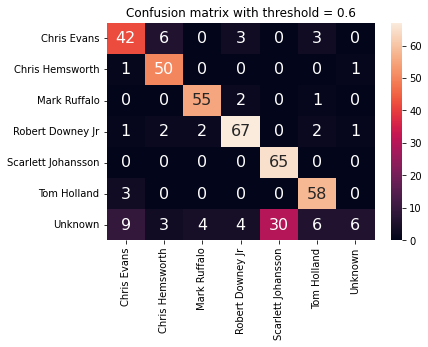

In [22]:
print("Phương pháp 2: Naive Neighbour candidate + Small dataset")
show_result(small_naive_neighbour_recognition_result, y_test_small, threshold=0.6)